Lectures on RL: MC evaluation and MC control

Welcome to today's hands-on implementation of every-visit montecarlo!

You can make a copy of this notebook by creating a new notebook and copy and pasting all cells.

Run the following code to upload to your Google Colab folder the necessary files. First download from Canvas announcements the files gym.zip and plot_utils.py. Then run the code below to select them and upload them to your Colab environment.

In [ ]:
# from zipfile import ZipFile
# from google.colab import files
# files.upload() IGNORE

gym.py is an environment provided by the private laboratory OpenAI who is behind DALL-E and GPT-3. It contains various environments that simulate games such as playing Blackjack or dynamic systems such as a dynamic cartpole or dynamic walking avatars.

We extract the gym.zip file which contains many games and environments.

In [ ]:
# with ZipFile("gym.zip", 'r') as zipfile_name:
#   zipfile_name.extractall()
#   print('Done')  IGNORE

Done


Now that Colab contains the environments we can import the libraries gym and plot_utils to plot the value function. We will use defauldict as a python dictionary that allows to return values for dictionaries out-of-bounds.

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict
from plot_utils import plot_blackjack_values, plot_policy

Loading blackjack gym environment from OpenAI. Blackjack is played between a player and a dealer. The goal is to get 21 points by using cards ace-10 and jack-queen-king. Ace doubles as a 1 or 11 to the players advantage. The player and dealer get one card. The player can ask to hit or stick. Hit gives additional cards to the player. Their goal is to get as close to 21 as possible. Once they stick, the dealer draws to try to beat the player.

In [2]:
env = gym.make('Blackjack-v1') # upgraded from Blackjack-v0

Observations are the 32 possible card combinations for the player, the 11 possible points of the dealer, and weather the player has an ace or not.

In [3]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Exploring blackjack environment. Trying some rollouts from the environment. We simulate three episodes from the environment. The player gets a reward of 1 if they win the episode. We are done if the player wins or loses.

In [4]:
for i_episode in range(3):
    state = env.reset()[0]

    while True:
        print(state)
        action = env.action_space.sample() # It choses hit or stick uniformly
        state, reward, done, info, unknown  = env.step(action)

        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(17, 2, False)
(18, 2, False)
End game! Reward:  -1.0
You lost :(

(13, 5, False)
End game! Reward:  -1.0
You lost :(

(20, 10, False)
End game! Reward:  -1.0
You lost :(



/home/caleb/Documents/course_work/ASE 389/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Let's generate episodes with a heuristic policy. If player points are less than 18, the player will hit 80% of the time.

In [5]:
def generate_episode_from_limit_stochastic(bj_env):
    episode = [] # a list
    state = bj_env.reset()[0] # initial state. tuple: state is player points, dealer car points, player has usable ace
    # e.g. (18, 4, False)

    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8] # list with Bernouilli distribution
        action = np.random.choice(np.arange(2), p=probs) # arange returns [0,1]
        next_state, reward, done, info, unknown = bj_env.step(action) # take a step in the simulation
        episode.append((state, action, reward)) # create a long list of tuples during the rollout
        state = next_state
        if done: # we are done when we lose or win
        	break

    return episode

Let's try this policy and see what episodes it returns.

In [6]:
for i in range(3):
	# generate_episode_from_limit_stochastic(env)
    print(generate_episode_from_limit_stochastic(env))

[((14, 2, False), 1, -1.0)]
[((5, 10, False), 1, 0.0), ((7, 10, False), 1, 0.0), ((16, 10, False), 1, 0.0), ((20, 10, False), 0, -1.0)]
[((17, 7, True), 1, 0.0), ((15, 7, False), 1, 0.0), ((18, 7, False), 1, -1.0)]


This will be used to return value of dictionary when keys are out of bounds (it's a technicality)

In [7]:
def out_of_bounds():
	return [0,0]

Quick intro to Python dictionaries

In [8]:
dictt = {1: 'Geeks', 'name': 'For', 3: 'Geeks'} # key and value
print(dictt[1])
print(dictt['name'])
print(dictt[5]) # will generate error - we show it to highlight problems with dictionaries

Geeks
For


KeyError: 5

More dictionaries

In [9]:
# another dictionary
dictt = {1: [3,0], 2: [4,1]} # values are lists
print(dictt[1])
print(dictt[1][0])

[3, 0]
3


Let's implement every visit MC computation of Q-Table. Returns_sum is a dictionary indexed by state keys (similar to hash_maps in C++) and has values consisting of cumulative reward obtained by following the heuristic policy after taking a hit or stick action. N is the number of times a particular (s,a) pair appears in all episode (every visit). Q is the action value function for (s,a) pairs.

In [11]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):

    # initialize empty dictionaries
    # action space is 2 (hit or stick)
    # the default value correspond value returned if out of bounds
    returns_sum = defaultdict(out_of_bounds) # out_of_bounds is the return if dictionary is out of bounds
    N = defaultdict(out_of_bounds)
    Q = defaultdict(out_of_bounds)

    # loop over episodes
    for ii_episode in range(1, num_episodes+1):

      # monitor progress by printing message every 1000 episodes
	    if ii_episode % 1000 == 0:
	    	print("\rEpisode {}/{}.".format(ii_episode, num_episodes), end="")

	    # generate episodes from black jack environment, MC every visit, builtin
	    episode = generate_episode(env)

      # episode is a lsit. *list means it's iteratable, i.e. lists are iteratables
	    states, actions, rewards = zip(*episode) # creates separate tuples for (s,a,r) across episode; zip aggregates them in tuple

	    # Q-table computation based on every-visit MC prediction
	    for ii, state in enumerate(states): # ii is iterable index; The enumerate () method adds a counter to an iterable
	    	cumul_rewards = sum(rewards[ii:]) # sum of future rewards until end of rewards tuple
	    	# here we assume dictionary returns_sum = {state : [G_action1 == hit, G_action2 == stick], ...}
	    	returns_sum[states[ii]][actions[ii]] += cumul_rewards
	    	N[states[ii]][actions[ii]] += 1.0
	    	Q[states[ii]][actions[ii]] = returns_sum[states[ii]][actions[ii]] / N[states[ii]][actions[ii]]

    return Q

Compute the action value table / function for many monte carlos rollouts (episodes)

In [17]:
Q = mc_prediction_q(env, 300000, generate_episode_from_limit_stochastic)

Episode 300000/300000.

Obtain the corresponding state-value function. k are keys for the Q-table (states of player, dealer, and ace tuples). v is the q value. This is still in progress.

In [14]:
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

In [15]:
V_to_plot = dict((k,np.max(v)) for k, v in Q.items())

Plot the state-value function

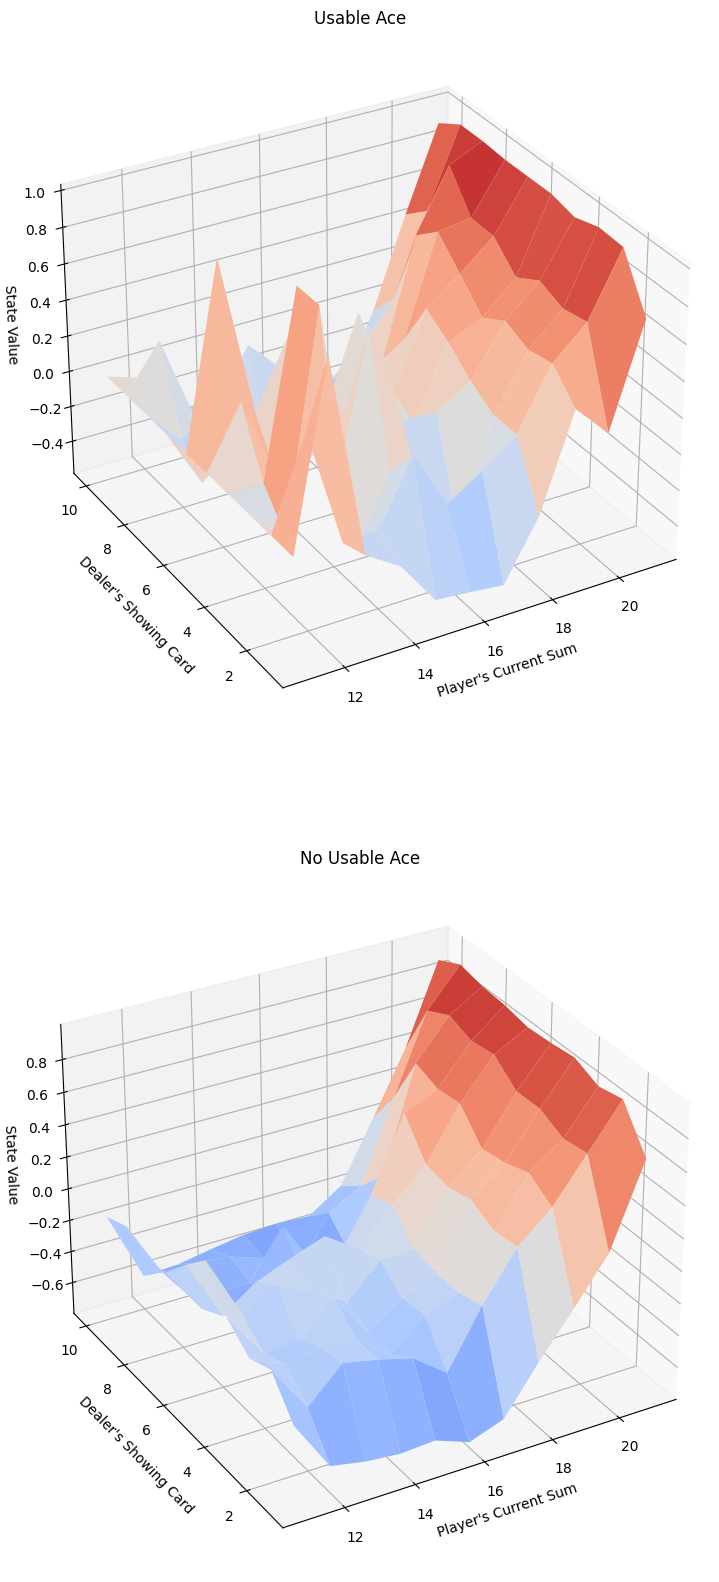

In [16]:
plot_blackjack_values(V_to_plot)

Lecture Tuesday 10/25: MC Control


In [ ]:
def generate_episode_from_Q(env, Q, epsilon):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()[0]
    while True:
        action = np.random.choice(np.arange(2), p=get_probs(Q[state], epsilon)) \
                                    if state in Q else env.action_space.sample() # 2nd option is random
        next_state, reward, done, info, unknown = env.step(action) # perform step (card delt)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(2) * epsilon / 2 # 2 is num of actions
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / 2) # policy_s is a dictionary indexed by best_a
    return policy_s

# incremental mean with constant alpha
def update_Q(env, episode, Q, alpha):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]) - old_Q)
    return Q

Control

In [18]:
def mc_control(env, num_episodes, alpha, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = 2
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start # e.g. 1
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items()) # k, np.argmax(v) are state action pairs
    return policy, Q

Obtain policy

In [19]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 150000, 0.02)

defaultdict(<function mc_control.<locals>.<lambda> at 0x7f1255cf5d30>, {})


NameError: name 'generate_episode_from_Q' is not defined

Plot value function:

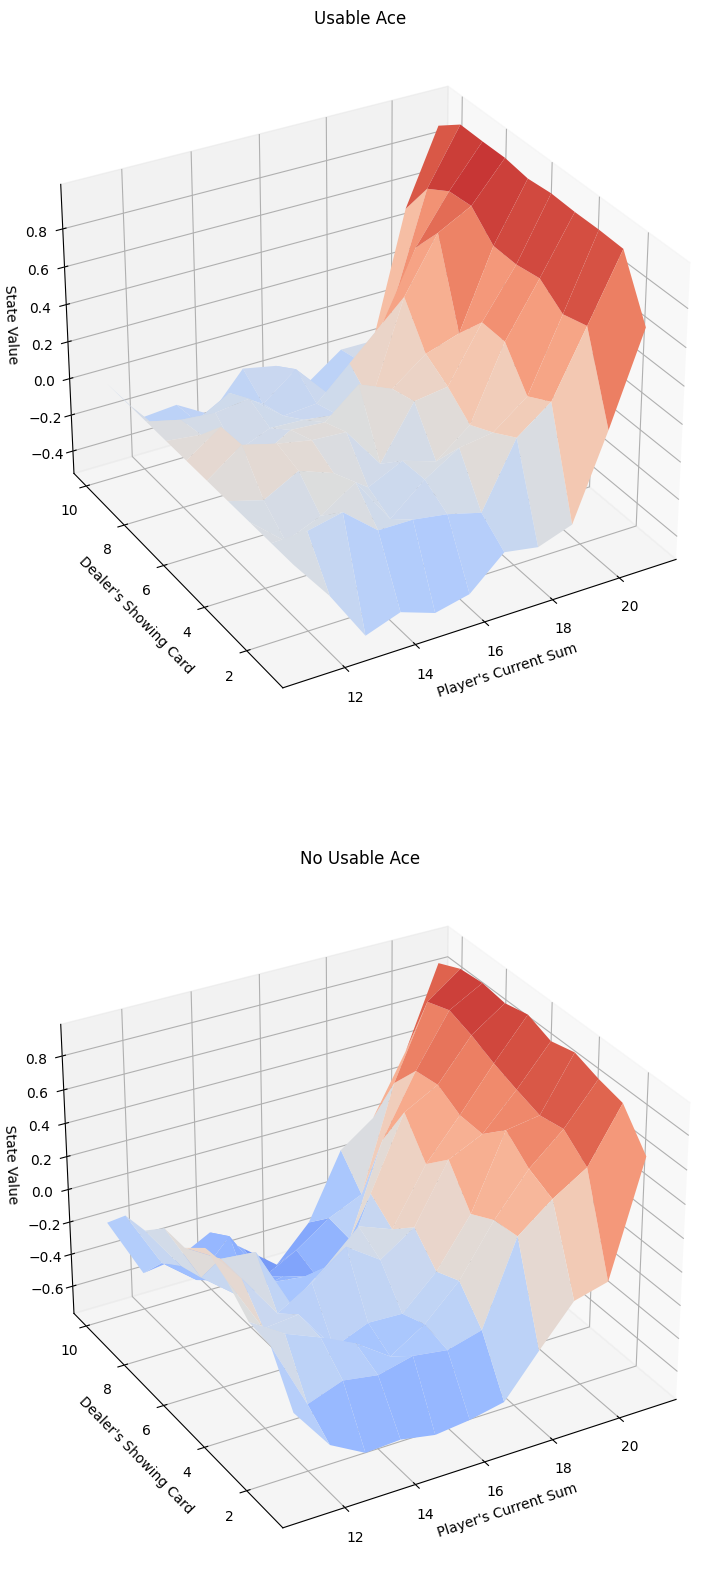

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Plot policy

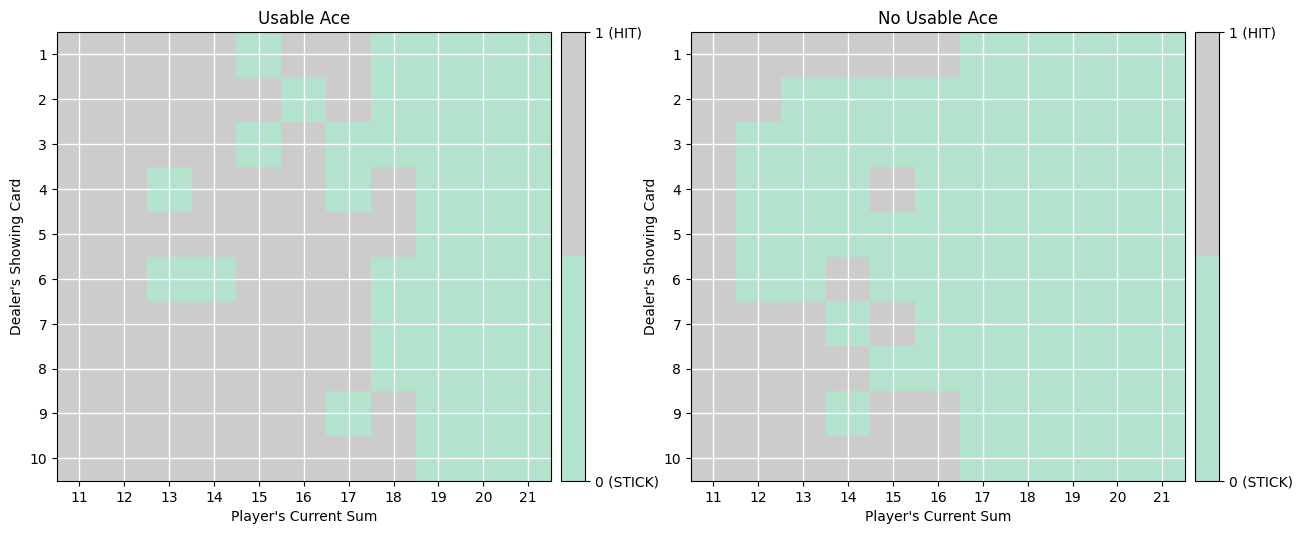

In [ ]:
# plot the policy
plot_policy(policy)

Optimal policy: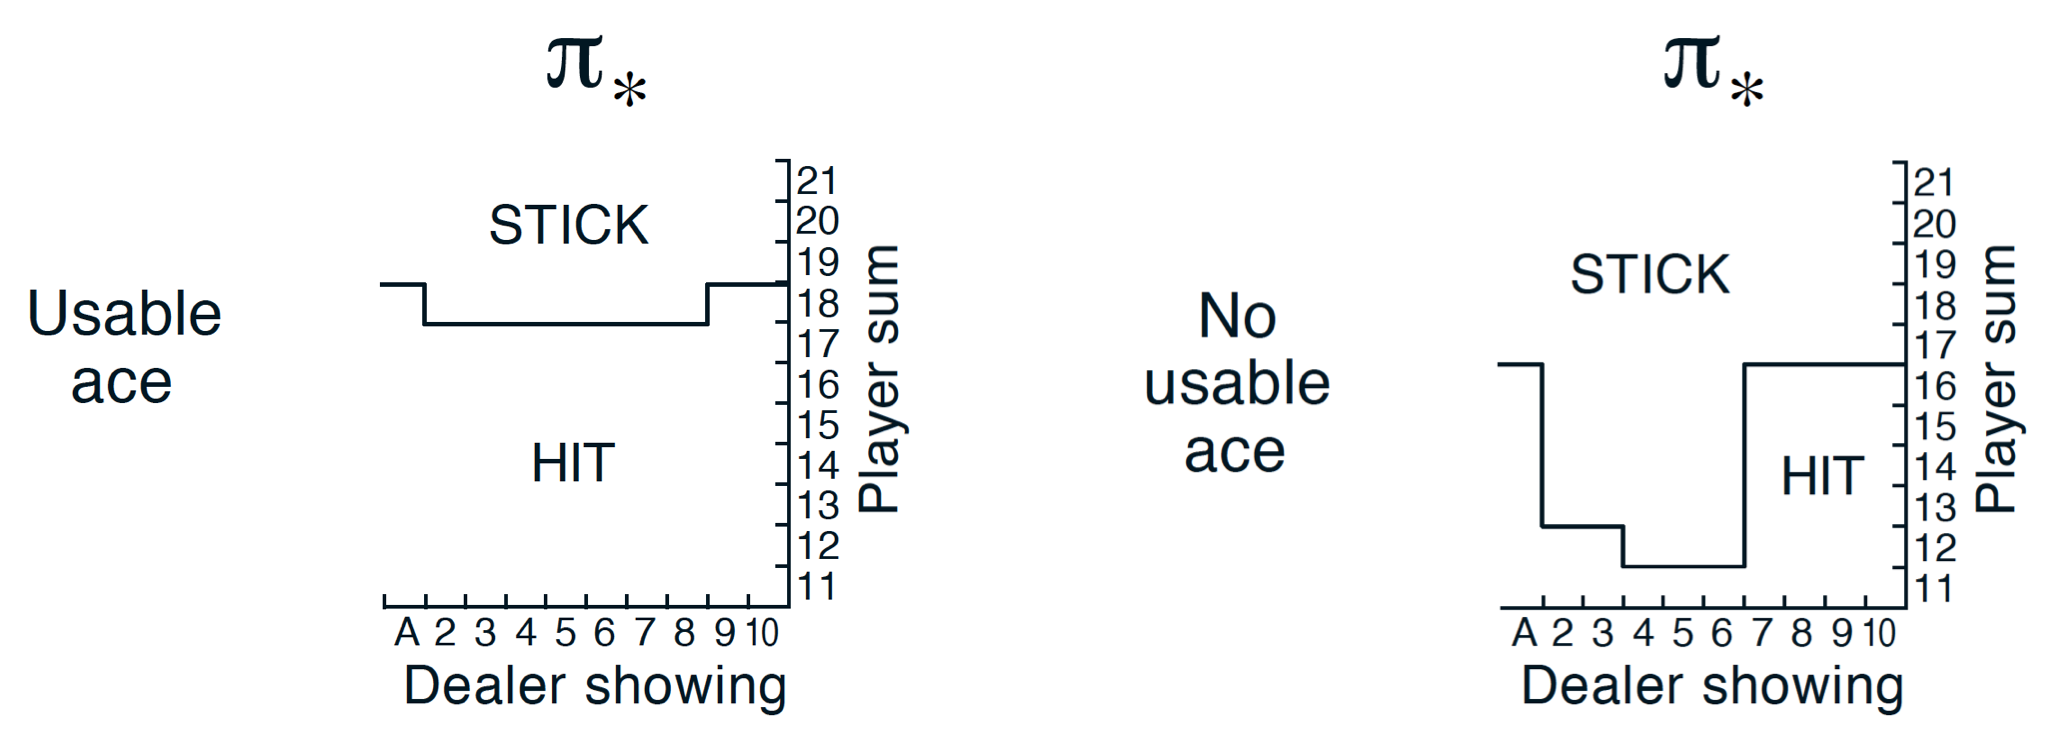